# Montney: Results (max_iter=20)

In [1]:
# import libraries
import numpy as np
import pandas as pd
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1. Data Pre-processing

In [2]:
# montney dataset
montney = pd.read_csv(filepath_or_buffer='dataset_montney.csv', low_memory=False)
montney.head()

,WELL_ID,DISPLAY_NAME,YEAR,X,Y,DEPTH,DENSITY,GR,SONIC,RESISTIVITY,SP,POROSITY,CALIPER,BITSIZE,TOC_CORE,TOC_CUTTINGS,LITHO,ORDER_3,ORDER_4
0,100031508122W500,0/03-15-081-22W5,2001,477579.55677,6.207776e+06,825.620,2.477900,81.453,255.236,4.782,-20.340,21.909,164.721,NaN,NaN,NaN,MONTNEY FM,Sequence 2,LST2
1,100031508122W500,0/03-15-081-22W5,2001,477579.55677,6.207776e+06,825.745,2.496034,85.738,255.687,4.793,-18.998,21.502,165.051,NaN,NaN,NaN,MONTNEY FM,Sequence 1,TST1
2,100031508122W500,0/03-15-081-22W5,2001,477579.55677,6.207776e+06,825.870,2.522904,93.034,258.596,4.499,-15.166,21.561,164.248,NaN,NaN,NaN,MONTNEY FM,Sequence 1,TST1
3,100031508122W500,0/03-15-081-22W5,2001,477579.55677,6.207776e+06,825.995,2.548484,102.140,264.808,4.126,-8.029,22.043,163.497,NaN,NaN,NaN,MONTNEY FM,Sequence 1,TST1
4,100031508122W500,0/03-15-081-22W5,2001,477579.55677,6.207776e+06,826.120,2.566674,111.973,273.186,3.567,-0.953,23.000,165.123,NaN,NaN,NaN,MONTNEY FM,Sequence 1,TST1


In [3]:
# rename columns
montney.rename(columns={'DENSITY': 'RHOB', 
                        'SONIC': 'DT',
                        'RESISTIVITY': 'RES', 
                        'POROSITY': 'NPHI',
                        'ORDER_4': 'STRAT'
                       }, inplace=True
              )

In [4]:
# drop unnecessary columns
montney.drop(['DISPLAY_NAME', 'CALIPER', 'BITSIZE', 'TOC_CUTTINGS', 'ORDER_3'], axis=1, inplace=True)

In [5]:
# handle outliers and well-log transformation

# replace sonic values smaller than 0 for NaN values
mask = montney['DT'] < 0
montney.loc[mask, 'DT'] = np.nan

# replace resistivity values smaller than or equal to 0 for NaN values
mask = montney['RES'] <= 0
montney.loc[mask, 'RES'] = np.nan

# create a new column to store log base 10 of resistivity
montney['RES_10'] = np.log10(montney['RES']+1)

# replace neutron porosity values smaller than 0 for NaN values
mask = montney['NPHI'] < 0
montney.loc[mask, 'NPHI'] = np.nan

# convert percentage to fraction
def convert_neutron(x):
    return x / 100

montney['NPHI'] = montney['NPHI'].apply(convert_neutron)

In [6]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']

In [7]:
# label encoding for well id
well_encoder = LabelEncoder()
montney['WELL'] = well_encoder.fit_transform(montney['WELL_ID'])


In [8]:
# columns
montney.columns

Index(['WELL_ID', 'YEAR', 'X', 'Y', 'DEPTH', 'RHOB', 'GR', 'DT', 'RES', 'SP',
       'NPHI', 'TOC_CORE', 'LITHO', 'STRAT', 'RES_10', 'WELL'],
      dtype='object')

In [9]:
# feature selection
selected_features = ['WELL', 'X', 'Y', 'DEPTH', 
                     'RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI',
                     'LITHO', 'STRAT']

## 2. Data Splitting

In [10]:
# copy of the dataset for modeling
data_ml = montney[selected_features].copy()

In [11]:
# well test selection
test_wells = well_encoder.transform(['100042408423W600', '100041606522W500', '100071406522W500', 
                                     '100111408125W500', '100143207308W600', '100162407706W600'])

# mask for test well
test_mask = data_ml['WELL'].isin(test_wells)

# column to identify train and test wells
data_ml['train_test'] = 'Train'
data_ml.loc[test_mask, 'train_test'] = 'Test'

# fraction of data
train_fraction = data_ml[data_ml['train_test'] == 'Train'].shape[0] / data_ml.shape[0]
test_fraction = data_ml[data_ml['train_test'] == 'Test'].shape[0] / data_ml.shape[0]
print(f"Fraction of data in train set: {train_fraction:.2f}")
print(f"Fraction of data in test set: {test_fraction:.2f}")
print(f"Total number of samples in dataset: {data_ml.shape[0]}")

Fraction of data in train set: 0.85
Fraction of data in test set: 0.15
Total number of samples in dataset: 122374


In [12]:
# create train and test sets
train = data_ml[~test_mask].copy()
test = data_ml[test_mask].copy()

## 3. Results

### Test

In [13]:
# results from mice
test_result_knr = pd.read_csv('test_result_knr.csv').add_suffix('_KNR')
test_result_br = pd.read_csv('test_result_br.csv').add_suffix('_BR')
test_result_rf = pd.read_csv('test_result_rf.csv').add_suffix('_RF')
test_result_xgb = pd.read_csv('test_result_xgb.csv').add_suffix('_XGB')

In [14]:
# create a copy of test data
test_df = test.copy()
test_df.reset_index(drop=True, inplace=True)

# merge mice results with the test data
test_df = test_df.merge(test_result_knr, left_index=True, right_index=True)
test_df = test_df.merge(test_result_br, left_index=True, right_index=True)
test_df = test_df.merge(test_result_rf, left_index=True, right_index=True)
test_df = test_df.merge(test_result_xgb, left_index=True, right_index=True)

In [15]:
test_df

,WELL,X,Y,DEPTH,RHOB,GR,DT,RES_10,SP,NPHI,...,DT_IMP_SCALED_XGB,RES_10_IMP_SCALED_XGB,SP_IMP_SCALED_XGB,NPHI_IMP_SCALED_XGB,RHOB_IMP_XGB,GR_IMP_XGB,DT_IMP_XGB,RES_10_IMP_XGB,SP_IMP_XGB,NPHI_IMP_XGB
0,1,482271.499734,6.052463e+06,1911.495,2.611854,149.843,226.255,1.277793,-143.182,0.112,...,0.214340,0.416548,0.527362,0.254314,2.598703,101.611825,203.824915,2.248561,337.538244,0.161667
1,1,482271.499734,6.052463e+06,1911.595,2.600693,125.852,216.665,1.241173,-141.921,0.115,...,0.215323,0.427624,0.316763,0.252132,2.610415,86.637869,204.137819,2.300795,58.090882,0.160280
2,1,482271.499734,6.052463e+06,1911.695,2.589293,103.401,208.990,1.212560,-140.275,0.118,...,0.235898,0.291869,0.281301,0.240113,2.616913,73.972600,210.687685,1.660600,11.035908,0.152640
3,1,482271.499734,6.052463e+06,1911.795,2.577893,81.066,203.973,1.196121,-138.609,0.121,...,0.235899,0.294481,0.163805,0.243065,2.632849,54.527125,210.688146,1.672916,-144.871099,0.154516
4,1,482271.499734,6.052463e+06,1911.895,2.566492,58.731,200.262,1.184606,-136.542,0.125,...,0.217826,0.265264,0.152310,0.147031,2.635214,40.190292,204.934712,1.535136,-160.124363,0.093468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18641,16,388301.987252,6.173343e+06,1701.400,2.555700,150.120,199.460,0.674310,20.170,0.296,...,0.560469,0.260970,0.267435,0.231340,2.710757,128.190429,314.012915,1.514887,-7.362538,0.147063
18642,16,388301.987252,6.173343e+06,1701.600,2.624900,81.495,195.760,0.651181,18.500,0.253,...,0.469735,0.254660,0.284187,0.188217,2.711554,110.494541,285.128261,1.485133,14.866050,0.119650
18643,16,388301.987252,6.173343e+06,1701.800,2.626500,45.150,192.320,0.586475,14.640,0.258,...,0.462785,0.188552,0.363240,0.200198,2.656408,80.189891,282.915906,1.173378,119.761851,0.127266
18644,16,388301.987252,6.173343e+06,1702.000,2.639500,56.625,192.500,0.546296,11.280,0.281,...,0.453395,0.221444,0.402483,0.212798,2.699059,113.297790,279.926495,1.328492,171.833993,0.135276


### 3.1. MICE Performance

In [16]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']
models = ['KNR', 'BR', 'RF', 'XGB']

evaluation_results = {}
for log in well_logs:
    
    evaluation_results[log] = {}
    for model in models:

        column_name = f'{log}_{model}'
        
        original_values = test_df[f'{log}_SCALED_{model}'].dropna()
        original_index = list(original_values.index.values)
        imputed_values = test_df.loc[original_index, f'{log}_IMP_SCALED_{model}']
        
        mae = mean_absolute_error(original_values, imputed_values)
        mse = mean_squared_error(original_values, imputed_values)
        r2 = r2_score(original_values, imputed_values)
        
        evaluation_results[log][model] = {'R2': r2, 'NMAE': mae, 'NMSE': mse}

evaluation_results_df = {}
for log, models in evaluation_results.items():
    
    table_data = []
    for model, metrics in models.items():
        cols = {'Model': model, 'R2': metrics['R2'], 'NMAE': metrics['NMAE'], 'NMSE': metrics['NMSE']}
        table_data.append(cols)
    
    df = pd.DataFrame(table_data)
    
    evaluation_results_df[log] = df

for log, df in evaluation_results_df.items():
    print(f'Well-log: {log}')
    display(df.round(4).sort_values('NMSE', ascending=True))
    print('\n')

Well-log: RHOB


,Model,R2,NMAE,NMSE
3,XGB,0.4318,0.0307,0.0022
2,RF,0.3725,0.0321,0.0024
1,BR,0.2119,0.0403,0.0031
0,KNR,-0.0729,0.0444,0.0042




Well-log: GR


,Model,R2,NMAE,NMSE
1,BR,-1.1526,0.0482,0.0044
0,KNR,-1.3082,0.0468,0.0047
2,RF,-1.9974,0.0527,0.0061
3,XGB,-2.1592,0.0535,0.0064




Well-log: DT


,Model,R2,NMAE,NMSE
1,BR,0.2214,0.0368,0.0033
2,RF,0.1257,0.0377,0.0037
3,XGB,-0.0118,0.0387,0.0043
0,KNR,-0.1200,0.0429,0.0047




Well-log: RES_10


,Model,R2,NMAE,NMSE
3,XGB,0.0701,0.1078,0.0177
2,RF,-0.1493,0.1229,0.0219
0,KNR,-0.1937,0.1207,0.0227
1,BR,-0.3111,0.1185,0.0250




Well-log: SP


,Model,R2,NMAE,NMSE
2,RF,-13.9483,0.1250,0.0439
0,KNR,-18.0938,0.1551,0.0561
3,XGB,-22.3888,0.1437,0.0687
1,BR,-23.8589,0.1942,0.0730




Well-log: NPHI


,Model,R2,NMAE,NMSE
0,KNR,0.1146,0.0732,0.0080
2,RF,0.0982,0.0729,0.0081
3,XGB,0.1020,0.0726,0.0081
1,BR,-0.1895,0.0805,0.0107


In [17]:
r2_results_df = pd.DataFrame()
mae_results_df = pd.DataFrame()
mse_results_df = pd.DataFrame()

for log, df in evaluation_results_df.items():
    r2_results_df[log] = df['R2']
    mae_results_df[log] = df['NMAE']
    mse_results_df[log] = df['NMSE']

r2_results_df.index = df['Model']
mae_results_df.index = df['Model']
mse_results_df.index = df['Model']
    

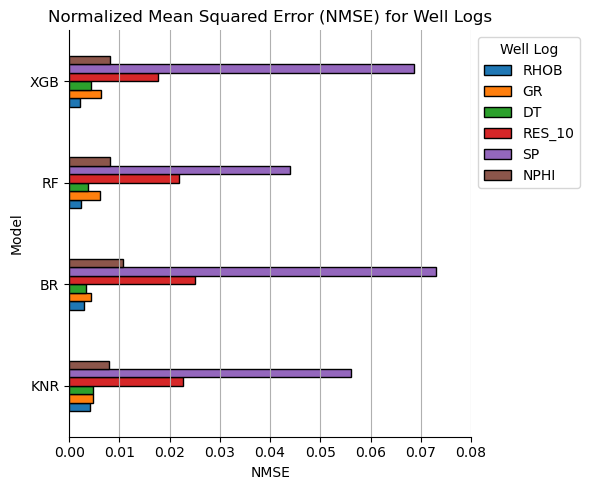

Model,KNR,BR,RF,XGB
RHOB,0.0042,0.0031,0.0024,0.0022
GR,0.0047,0.0044,0.0061,0.0064
DT,0.0047,0.0033,0.0037,0.0043
RES_10,0.0227,0.0250,0.0219,0.0177
SP,0.0561,0.0730,0.0439,0.0687
NPHI,0.0080,0.0107,0.0081,0.0081


In [20]:

ax = mse_results_df.plot(kind='barh', figsize=(6, 5), edgecolor='black')

plt.title('Normalized Mean Squared Error (NMSE) for Well Logs')
plt.ylabel('Model')
plt.xlabel('NMSE')

plt.xticks(rotation='horizontal')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.grid(True)
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))

ax.set_xlim([0, 0.08])

plt.tight_layout() 
plt.show()

display(mse_results_df.T.round(4))


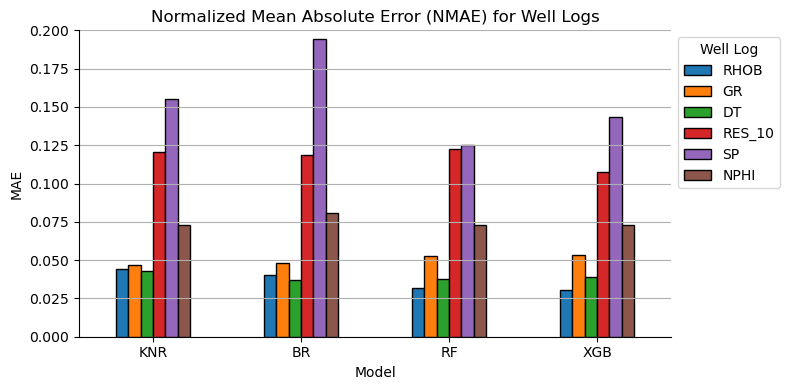

Model,KNR,BR,RF,XGB
RHOB,0.0444,0.0403,0.0321,0.0307
GR,0.0468,0.0482,0.0527,0.0535
DT,0.0429,0.0368,0.0377,0.0387
RES_10,0.1207,0.1185,0.1229,0.1078
SP,0.1551,0.1942,0.1250,0.1437
NPHI,0.0732,0.0805,0.0729,0.0726


In [19]:
ax = mae_results_df.plot(kind='bar', figsize=(8, 4), edgecolor='black')

plt.title('Normalized Mean Absolute Error (NMAE) for Well Logs')
plt.xlabel('Model')
plt.ylabel('MAE')

plt.xticks(rotation='horizontal')
plt.ylim(0, 0.2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True)
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))

plt.tight_layout() 
plt.show()

display(mae_results_df.T.round(4))

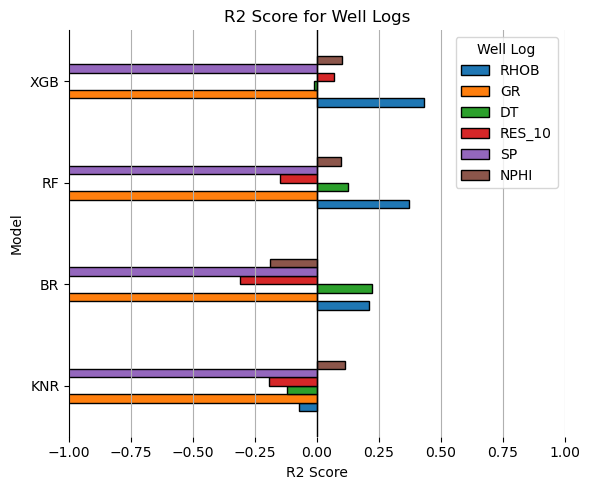

Model,KNR,BR,RF,XGB
RHOB,-0.07,0.21,0.37,0.43
GR,-1.31,-1.15,-2.00,-2.16
DT,-0.12,0.22,0.13,-0.01
RES_10,-0.19,-0.31,-0.15,0.07
SP,-18.09,-23.86,-13.95,-22.39
NPHI,0.11,-0.19,0.10,0.10


In [19]:

ax = r2_results_df.plot(kind='barh', figsize=(6, 5), edgecolor='black')

plt.title('R2 Score for Well Logs')
plt.ylabel('Model')
plt.xlabel('R2 Score')
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))
plt.xticks(rotation='horizontal')
plt.axvline(0, color='black', linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.grid(True)

ax.set_xlim([-1, 1])

plt.tight_layout()  
plt.show()
display(r2_results_df.T.round(2))